# CS5814: Assignment 1

## Problem 2

### Imports and config

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Supressing Jupyter Notebook torchvision installation error 

import torch
from torchvision import transforms, datasets
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import random

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
RANDOM_SEED = 3819969

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 1: PyTorch implementation with dropout (p=0.25) [15]

MNIST data is first downloaded, before 50% of both training and test data is discarded - resulting in 30,000 and 5,000 test and training isntances respectively.

The data is additionally normalized such that pixels have a value betten 0-1, by dividing by the mean and std of the MNIST data set (0.1307 and 0.3081 respectively)

In [3]:
def download_data():
    train = datasets.MNIST("", train=True, download=True,
                           transform=transforms.Compose(
                               [transforms.ToTensor()]))

    train = data_utils.Subset(train, torch.randperm(len(train))[:int(0.5 * len(train))])

    # Testing data
    test = datasets.MNIST("", train=False, download=True,
                          transform=transforms.Compose(
                              [transforms.ToTensor()]))

    test = data_utils.Subset(test, torch.randperm(len(test))[:int(0.5 * len(test))])

    # Loading the datasets
    trainset = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
    testset = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)

    return trainset, testset

trainset, testset = download_data()

The network is defined below, along with the validation and training loops

In [4]:
class DenseNetwork(nn.Module):
    def __init__(self, dropout_rate = 0.5):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, enable_dropout=True):
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(x, dim=1)

        return x

In [5]:
def validate(model, criterion):
    # Validation loop
    
    correct = 0
    total = 0
    model.eval()

    loss = 0
    
    with torch.no_grad():
        
        mini_batch_count = 0
        for X, y in trainset:
            X, y = X.to(device), y.to(device)
            output = model(X.view(-1, 784))
            correct += sum(output.argmax(axis=1) == y).item()
            total += X.shape[0]
            
            loss += criterion(output,y)
            mini_batch_count += 1
            

    model.train()

    return correct / total, loss.item()/mini_batch_count

In [6]:
def training(model, optimizer, criterion, epochs=5):
    # Main training loop for a given model, optimizer and evaluation criterion
    
    loss = 0  
    weight_updates = 0  # Number of weight updates conducted

    # Arrays for tracking training metrics
    train_error_array = []
    train_loss_array = []
    train_loss_smooth_array = []
    mini_batch_error_array = []
    val_weight_update_array = []
    val_error_array = []
    val_loss_array = []
    
    for epoch in range(epochs):
        mini_batch_id = 0
        correct = 0
        
        total = 0
        for X, y in trainset:

            X, y = X.to(device), y.to(device)
            model.zero_grad()
            
            # Forward step
            output = model.forward(X.view(-1, 28 * 28))
            
            # Accuracy calculations and updating accuracy arrays
            correct += sum(output.argmax(axis=1) == y).item()
            total += X.shape[0]
            train_error = 1-(correct/total)
            mini_batch_error_array.append(1-(sum(output.argmax(axis=1) == y).item()/X.shape[0]))
            mini_batch_error_avg = np.average(mini_batch_error_array[-100:])
            train_error_array.append(mini_batch_error_avg)
            
            # Backward step
            loss = criterion(output, y)           
            loss.backward()
            optimizer.step()
            
            # Updaing loss arrays
            train_loss_array.append(loss.item())
            train_loss_smooth = np.average(train_loss_array[-100:])
            train_loss_smooth_array.append(train_loss_smooth)
            
            # Validation (every 100 minibatches)
            # Additional clause added as first validation on epoch would be based on 1 mini batch (therefore skewed)
            if mini_batch_id % 100 == 0 and (mini_batch_id > 0 or epoch == 0):             

                val_accuracy, val_loss = validate(model, criterion)
                
                val_weight_update_array.append(weight_updates)
                val_error_array.append(1-val_accuracy)
                val_loss_array.append(val_loss)
                
                model.train()  # Renable training after validation
                
                print("Epoch: {}, Batch number: {}, "
                      "Train_loss: {:.4f}, Train_error: {:.4f}, "
                      "Val_loss: {:.4f}, Val_error: {:.4f}".format(epoch,
                                                                      mini_batch_id,
                                                                      train_loss_smooth,
                                                                      train_error,
                                                                      val_loss,
                                                                      1-val_accuracy))
            

            mini_batch_id += 1
            weight_updates+= 1
            
    return train_error_array,mini_batch_error_array, train_loss_array,train_loss_smooth_array, val_error_array, val_loss_array, val_weight_update_array

Below is the plot function used for all experimets 

In [7]:
def q2_plot(data, optimizer, dropout):
    train_error_array,mini_batch_error_array, train_loss_array,train_loss_smooth_array, val_error_array, val_loss_array, val_weight_update_array = data
    
    fig, axs = plt.subplots(2,1)
    fig.set_size_inches(12, 16)
    
    fig.suptitle("Optimizer: {}, Dropout: {}".format(optimizer, dropout))
    fig.tight_layout(rect=[0, 0.08, 1, 0.98])
    fig.subplots_adjust(hspace = 0.2)

    
    axs[0].plot(mini_batch_error_array, alpha=0.8, label="Training [minibatch]")
    axs[0].plot(train_error_array, linewidth=3, color="red", label="Training [averaged]")
    axs[0].plot(val_weight_update_array, val_error_array, linewidth=3, color="black", label="Validation")
    axs[0].legend(loc="upper right")
    axs[0].set_title("Model Error")
    axs[0].set_xlabel("Weight update")
    axs[0].set_ylabel("Classification Error")
    axs[0].grid()

    axs[1].plot(train_loss_array, alpha=0.8, label="Training [minibatch]")
    axs[1].plot(train_loss_smooth_array, linewidth=3, color="red", label="Training [averaged]")
    axs[1].plot(val_weight_update_array, val_loss_array, linewidth=3, color="black", label="Validation")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Model Loss")
    axs[1].set_xlabel("Weight update")
    axs[1].set_ylabel("Loss")
    axs[1].grid()



###  SGD with dropout (p=0.25)

In [8]:
def Q1_SGD():
    model = DenseNetwork(dropout_rate=0.25).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    criterion = nn.CrossEntropyLoss()
    epochs = 2

    return(training(model, optimizer, criterion, epochs))

In [9]:
sgd_data = (Q1_SGD())

Epoch: 0, Batch number: 0, Train_loss: 2.3073, Train_error: 0.9375, Val_loss: 2.2590, Val_error: 0.8469
Epoch: 0, Batch number: 100, Train_loss: 1.0965, Train_error: 0.2899, Val_loss: 0.6635, Val_error: 0.1624
Epoch: 0, Batch number: 200, Train_loss: 0.5998, Train_error: 0.2228, Val_loss: 0.5105, Val_error: 0.1299
Epoch: 0, Batch number: 300, Train_loss: 0.5294, Train_error: 0.1964, Val_loss: 0.4594, Val_error: 0.1221
Epoch: 0, Batch number: 400, Train_loss: 0.4854, Train_error: 0.1817, Val_loss: 0.4318, Val_error: 0.1180
Epoch: 0, Batch number: 500, Train_loss: 0.4369, Train_error: 0.1703, Val_loss: 0.4036, Val_error: 0.1083
Epoch: 0, Batch number: 600, Train_loss: 0.4344, Train_error: 0.1630, Val_loss: 0.3913, Val_error: 0.1097
Epoch: 0, Batch number: 700, Train_loss: 0.4520, Train_error: 0.1585, Val_loss: 0.3776, Val_error: 0.1040
Epoch: 0, Batch number: 800, Train_loss: 0.4512, Train_error: 0.1545, Val_loss: 0.3685, Val_error: 0.1012
Epoch: 0, Batch number: 900, Train_loss: 0.4093,

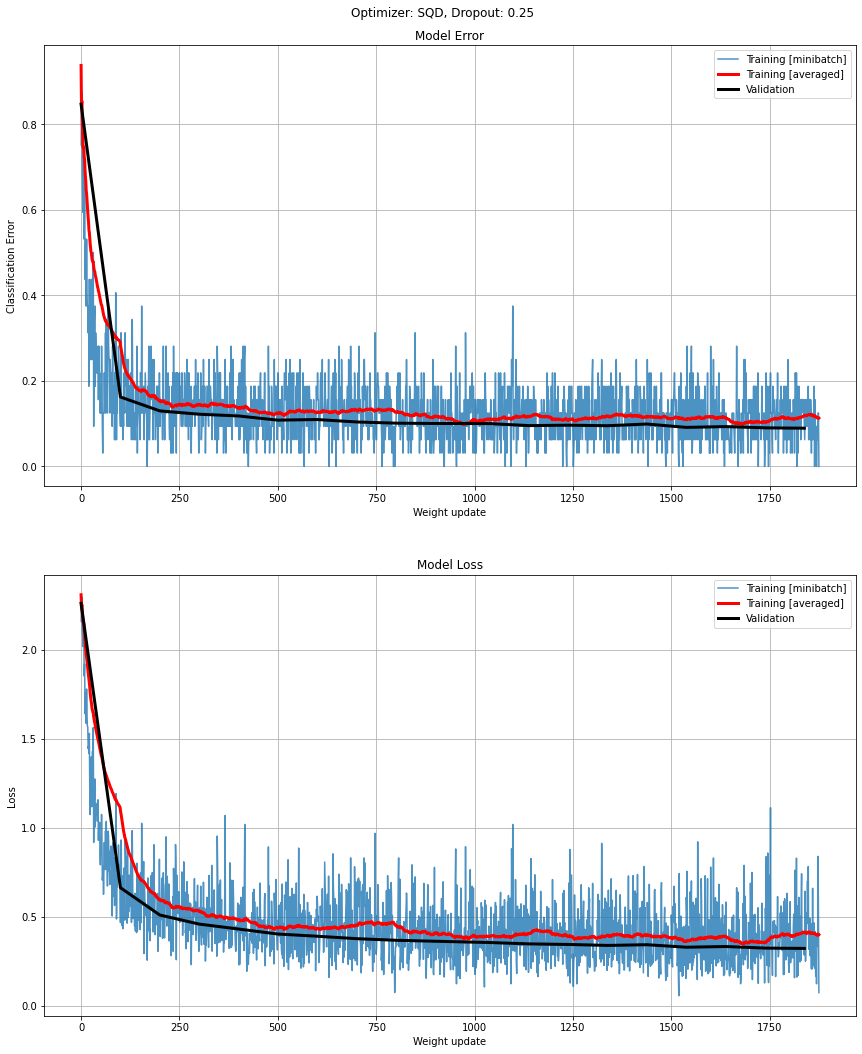

In [10]:
q2_plot(sgd_data, optimizer="SQD", dropout=0.25)

### 2: PyTorch implementation with Adam optimizer and dropout  (p=0.5) [15]

In [11]:
def Q2_ADAM():
    model = DenseNetwork(dropout_rate=0.5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    epochs = 2

    return(training(model, optimizer, criterion, epochs))

In [12]:
q2_adam_data = (Q2_ADAM())

Epoch: 0, Batch number: 0, Train_loss: 2.2875, Train_error: 0.8438, Val_loss: 2.2988, Val_error: 0.8991
Epoch: 0, Batch number: 100, Train_loss: 1.7090, Train_error: 0.4381, Val_loss: 1.0967, Val_error: 0.1957
Epoch: 0, Batch number: 200, Train_loss: 0.9535, Train_error: 0.3268, Val_loss: 0.7504, Val_error: 0.1546
Epoch: 0, Batch number: 300, Train_loss: 0.7433, Train_error: 0.2786, Val_loss: 0.6168, Val_error: 0.1378
Epoch: 0, Batch number: 400, Train_loss: 0.6648, Train_error: 0.2509, Val_loss: 0.5456, Val_error: 0.1250
Epoch: 0, Batch number: 500, Train_loss: 0.5901, Train_error: 0.2315, Val_loss: 0.4982, Val_error: 0.1188
Epoch: 0, Batch number: 600, Train_loss: 0.5605, Train_error: 0.2189, Val_loss: 0.4663, Val_error: 0.1157
Epoch: 0, Batch number: 700, Train_loss: 0.5185, Train_error: 0.2085, Val_loss: 0.4422, Val_error: 0.1105
Epoch: 0, Batch number: 800, Train_loss: 0.5095, Train_error: 0.1993, Val_loss: 0.4248, Val_error: 0.1104
Epoch: 0, Batch number: 900, Train_loss: 0.5222,

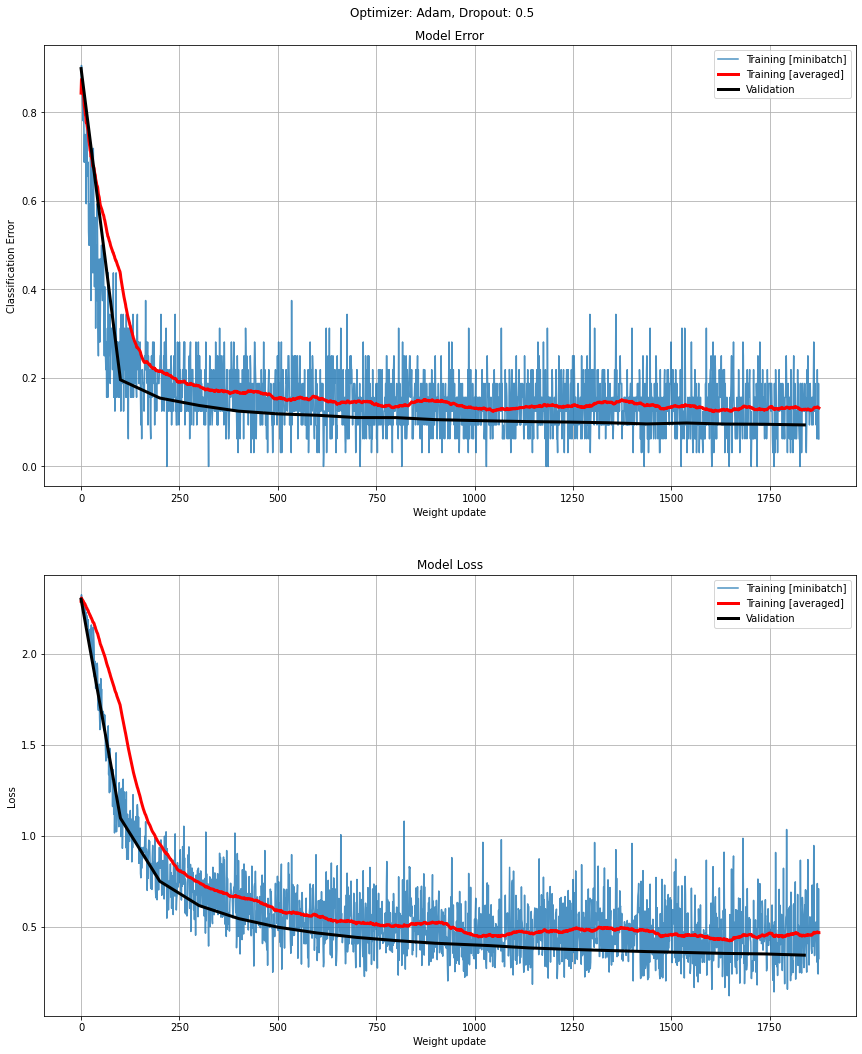

In [13]:
q2_plot(q2_adam_data, optimizer="Adam", dropout=0.5)